# Reinforment Learning Final Project

#### Student: Liqian Ma, Hualiang Qin, Wentao Yao, Xingbang Liu

# Background

User preference prediction has been studied intensely both in industry and academia recently. In order to improve the accuracy of this prediction, we have to consider the tradeoff between model efficiency and effectiveness for large-scale recommender systems given the time limit of responding. For millions or even tens of millions of items among the corpus, this system should recommend k items. Under which conditions, it is impractical to recommend the top items and predict the preference score of each user-item pair. Focusing on this problem, we want to tackle problems like how to retrieve the top-k items for each user and avoid the intensive calculation in the meanwhile. This kind of problem is important and worth studying. 

# Dataset

The dataset comes from a competition held by Tianchi, a Chinese competition platform. Please refer to the [original website](https://github.com/massquantity/DBRL) for a full description. The training dataset has three files in total. They are the user behavior file, the user profile file and the item information file.

# Solutions

## Deep Deterministic Policy Gradient (DDPG)

DDPG stands for Deep Deterministic Policy Gradient, which uses four neural networks: a Q network, a deterministic policy network, a target Q network, and a target policy network. The Q network and policy network is a simple A2C algorithm, but in DDPG, the Actor directly maps states to actions(deterministic). The target networks are time-delayed copies of their original networks that slowly track the learned networks.

In [11]:
import torch
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
import warnings
from dbrl import *
from PIL import Image
warnings.filterwarnings("ignore")

In [2]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1erBjYEOa7IuOIGpI8pGPn1WNBAC4Rv0-' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1erBjYEOa7IuOIGpI8pGPn1WNBAC4Rv0-" -O 'trainset.zip' && rm -rf /tmp/cookies.txt

--2022-06-08 04:58:50--  https://docs.google.com/uc?export=download&confirm=t&id=1erBjYEOa7IuOIGpI8pGPn1WNBAC4Rv0-
Resolving docs.google.com (docs.google.com)... 142.250.191.142, 2607:f8b0:4009:818::200e
Connecting to docs.google.com (docs.google.com)|142.250.191.142|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-2s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7biojosfsf0i8b45osdbomkj9f0i5l55/1654664325000/16093452818886529866/*/1erBjYEOa7IuOIGpI8pGPn1WNBAC4Rv0-?e=download [following]
--2022-06-08 04:58:50--  https://doc-10-2s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7biojosfsf0i8b45osdbomkj9f0i5l55/1654664325000/16093452818886529866/*/1erBjYEOa7IuOIGpI8pGPn1WNBAC4Rv0-?e=download
Resolving doc-10-2s-docs.googleusercontent.com (doc-10-2s-docs.googleusercontent.com)... 172.217.5.1, 2607:f8b0:4009:807::2001
Connecting to doc-10-2s-docs.googleusercontent.com (doc-10-2s-docs.goog

In [3]:
!unzip trainset.zip

Archive:  trainset.zip
   creating: ECommAI_EUIR_round2_train_20190816/
  inflating: ECommAI_EUIR_round2_train_20190816/user_behavior.csv  
  inflating: ECommAI_EUIR_round2_train_20190816/item.csv  
  inflating: ECommAI_EUIR_round2_train_20190816/user.csv  


In [4]:
!mv ECommAI_EUIR_round2_train_20190816/item.csv dbrl/resources/item.csv
!mv ECommAI_EUIR_round2_train_20190816/user.csv dbrl/resources/user.csv
!mv ECommAI_EUIR_round2_train_20190816/user_behavior.csv dbrl/resources/user_behavior.csv

In [5]:
!python run_prepare_data.py

{'seed': 0}
n_users: 80000, n_items: 1047166, behavior length: 3234367
prepare data done!, time elapsed: 60.97


In [2]:
os.chdir('./dbrl/')

In [9]:
!python run_pretrain_embeddings.py --lr 0.001 --n_epochs 4

A list all args: 
{'batch_size': 2048,
 'data': 'tianchi.csv',
 'embed_size': 32,
 'loss': 'cosine',
 'lr': 0.001,
 'n_epochs': 4,
 'neg_item': 1,
 'seed': 0}

n_users: 80000, n_items: 912114, train_shape: (2587518, 10), eval_shape: (646849, 10)
100%|████████████████████████████████████████| 632/632 [00:06<00:00, 104.84it/s]
epoch 1, train_loss: 0.3307, eval loss: 0.3668, eval roc: 0.7203
100%|████████████████████████████████████████| 632/632 [00:06<00:00, 102.63it/s]
epoch 2, train_loss: 0.2682, eval loss: 0.3400, eval roc: 0.7604
100%|████████████████████████████████████████| 632/632 [00:06<00:00, 102.87it/s]
epoch 3, train_loss: 0.2339, eval loss: 0.3319, eval roc: 0.7726
100%|████████████████████████████████████████| 632/632 [00:06<00:00, 101.58it/s]
epoch 4, train_loss: 0.2104, eval loss: 0.3350, eval roc: 0.7737
user_embeds shape: (80000, 32), item_embeds shape: (912115, 32)
pretrain embeddings done!


In [3]:
!python run_ddpg.py --n_epochs 20 --lr 1e-5

A list all args: 
{'batch_size': 2048,
 'data': 'tianchi.csv',
 'gamma': 0.99,
 'hidden_size': 64,
 'hist_num': 10,
 'item_embeds': 'tianchi_item_embeddings.npy',
 'lr': 1e-05,
 'n_epochs': 20,
 'n_rec': 10,
 'policy_delay': 1,
 'seed': 0,
 'sess_mode': 'one',
 'tau': 0.001,
 'user_embeds': 'tianchi_user_embeddings.npy',
 'weight_decay': 0.0}

Number of parameters: actor: 28832,  critic: 28865
Caution: Will compute loss every 10 step(s)

Epoch 1 start-time: 2022-06-08 05:33:10

last_eval: 100%|██████████████████████████████| 40/40 [00:00<00:00, 2054.50it/s]

actor_loss: -1.3374, critic_loss: 0.8289, 
reward: 4, ndcg_next_item: 0.000011, ndcg_all_item: 0.000205, ndcg: 0.000166

******************** EVAL ********************
last_eval: 100%|██████████████████████████████| 40/40 [00:00<00:00, 3833.13it/s]

actor_loss: -3.0784, critic_loss: 0.5784, 
reward: 3, ndcg_next_item: 0.000009, ndcg_all_item: 0.000074, ndcg: 0.000030

Epoch 2 start-time: 2022-06-08 05:34:07

last_eval: 100%|███████

In [5]:
!python run_ddpg.py --n_epochs 20 --lr 1e-4

A list all args: 
{'batch_size': 2048,
 'data': 'tianchi.csv',
 'gamma': 0.99,
 'hidden_size': 64,
 'hist_num': 10,
 'item_embeds': 'tianchi_item_embeddings.npy',
 'lr': 0.0001,
 'n_epochs': 20,
 'n_rec': 10,
 'policy_delay': 1,
 'seed': 0,
 'sess_mode': 'one',
 'tau': 0.001,
 'user_embeds': 'tianchi_user_embeddings.npy',
 'weight_decay': 0.0}

Number of parameters: actor: 28832,  critic: 28865
Caution: Will compute loss every 10 step(s)

Epoch 1 start-time: 2022-06-08 06:24:44

last_eval: 100%|██████████████████████████████| 40/40 [00:00<00:00, 2047.70it/s]

actor_loss: -215985.4341, critic_loss: 196977.8763, 
reward: 11, ndcg_next_item: 0.000030, ndcg_all_item: 0.000864, ndcg: 0.001117

******************** EVAL ********************
last_eval: 100%|██████████████████████████████| 40/40 [00:00<00:00, 3867.59it/s]

actor_loss: -2449788.6673, critic_loss: 6262490.6885, 
reward: 9, ndcg_next_item: 0.000037, ndcg_all_item: 0.000165, ndcg: 0.000246

Epoch 2 start-time: 2022-06-08 06:25:41


In [6]:
!python run_ddpg.py --n_epochs 20 --lr 1e-5 --hidden_size 128

A list all args: 
{'batch_size': 2048,
 'data': 'tianchi.csv',
 'gamma': 0.99,
 'hidden_size': 128,
 'hist_num': 10,
 'item_embeds': 'tianchi_item_embeddings.npy',
 'lr': 1e-05,
 'n_epochs': 20,
 'n_rec': 10,
 'policy_delay': 1,
 'seed': 0,
 'sess_mode': 'one',
 'tau': 0.001,
 'user_embeds': 'tianchi_user_embeddings.npy',
 'weight_decay': 0.0}

Number of parameters: actor: 65824,  critic: 65921
Caution: Will compute loss every 10 step(s)

Epoch 1 start-time: 2022-06-08 06:43:33

last_eval: 100%|██████████████████████████████| 40/40 [00:00<00:00, 2228.76it/s]

actor_loss: -3.3834, critic_loss: 0.5525, 
reward: 2, ndcg_next_item: 0.000003, ndcg_all_item: 0.000189, ndcg: 0.000084

******************** EVAL ********************
last_eval: 100%|██████████████████████████████| 40/40 [00:00<00:00, 3575.25it/s]

actor_loss: -10.6588, critic_loss: 0.5101, 
reward: 0, ndcg_next_item: 0.000000, ndcg_all_item: 0.000000, ndcg: 0.000041

Epoch 2 start-time: 2022-06-08 06:44:32

last_eval: 100%|█████

In [7]:
!python run_ddpg.py --n_epochs 20 --lr 1e-5 --gamma 0.8

A list all args: 
{'batch_size': 2048,
 'data': 'tianchi.csv',
 'gamma': 0.8,
 'hidden_size': 64,
 'hist_num': 10,
 'item_embeds': 'tianchi_item_embeddings.npy',
 'lr': 1e-05,
 'n_epochs': 20,
 'n_rec': 10,
 'policy_delay': 1,
 'seed': 0,
 'sess_mode': 'one',
 'tau': 0.001,
 'user_embeds': 'tianchi_user_embeddings.npy',
 'weight_decay': 0.0}

Number of parameters: actor: 28832,  critic: 28865
Caution: Will compute loss every 10 step(s)

Epoch 1 start-time: 2022-06-08 07:02:20

last_eval: 100%|██████████████████████████████| 40/40 [00:00<00:00, 2571.85it/s]

actor_loss: -1.2978, critic_loss: 0.7801, 
reward: 4, ndcg_next_item: 0.000005, ndcg_all_item: 0.000205, ndcg: 0.000181

******************** EVAL ********************
last_eval: 100%|██████████████████████████████| 40/40 [00:00<00:00, 3917.16it/s]

actor_loss: -2.9064, critic_loss: 0.5225, 
reward: 3, ndcg_next_item: 0.000009, ndcg_all_item: 0.000065, ndcg: 0.000039

Epoch 2 start-time: 2022-06-08 07:03:16

last_eval: 100%|████████

## Batch Constrained Deep Q-Learning (BCQ)

Another algorithm we tried was the Batch-Constrained Deep Q-Learning (BCQ). This algorithm is introduced by Fujimoto et al. in paper Off-Policy Deep Reinforcement Learning without Exploration. BCQ can be seen as the offline scenario application of DDPG. The definition of batch (offline) reinforcement learning is that the data is isolated from the environment, which means no new data are accepted during learning. Under such settings, the reinforcement learning algorithms such as DQN and DDPG may result in extrapolation error. 

In [4]:
!python run_bcq.py --n_epochs 20 --lr 1e-5

A list all args: 
{'batch_size': 2048,
 'data': 'tianchi.csv',
 'gamma': 0.99,
 'hidden_size': 64,
 'hist_num': 10,
 'item_embeds': 'tianchi_item_embeddings.npy',
 'lr': 1e-05,
 'n_epochs': 20,
 'n_rec': 10,
 'policy_delay': 1,
 'seed': 0,
 'sess_mode': 'one',
 'tau': 0.001,
 'user_embeds': 'tianchi_user_embeddings.npy',
 'weight_decay': 0.0}

Number of parameters: generator: 98880,  perturbator: 30880,  critic1: 28865,  critic2: 28865
Caution: Will compute loss every 10 step(s)

Epoch 1 start-time: 2022-06-08 05:53:53

last_eval: 100%|████████████████████████████████| 40/40 [00:03<00:00, 13.16it/s]

generator_loss: 0.0681, perturbator_loss: -0.6383, critic_loss: 1.4746, y: 1.3354, q1: 0.6371, q2: 0.8034, mean: -0.0015, std: 0.9872, 
reward: 9, ndcg_next_item: 0.000021, ndcg_all_item: 0.000390, ndcg: 0.000397

******************** EVAL ********************
last_eval: 100%|████████████████████████████████| 40/40 [00:03<00:00, 13.12it/s]

generator_loss: 0.0412, perturbator_loss: -1.1704

In [8]:
!python run_bcq.py --n_epochs 20 --lr 1e-4

A list all args: 
{'batch_size': 2048,
 'data': 'tianchi.csv',
 'gamma': 0.99,
 'hidden_size': 64,
 'hist_num': 10,
 'item_embeds': 'tianchi_item_embeddings.npy',
 'lr': 0.0001,
 'n_epochs': 20,
 'n_rec': 10,
 'policy_delay': 1,
 'seed': 0,
 'sess_mode': 'one',
 'tau': 0.001,
 'user_embeds': 'tianchi_user_embeddings.npy',
 'weight_decay': 0.0}

Number of parameters: generator: 98880,  perturbator: 30880,  critic1: 28865,  critic2: 28865
Caution: Will compute loss every 10 step(s)

Epoch 1 start-time: 2022-06-08 07:21:10

last_eval: 100%|████████████████████████████████| 40/40 [00:02<00:00, 13.48it/s]

generator_loss: 0.0257, perturbator_loss: -1.5305, critic_loss: 0.5909, y: 1.6108, q1: 1.5286, q2: 1.5511, mean: -0.0001, std: 0.9907, 
reward: 46, ndcg_next_item: 0.000120, ndcg_all_item: 0.003431, ndcg: 0.002622

******************** EVAL ********************
last_eval: 100%|████████████████████████████████| 40/40 [00:02<00:00, 13.52it/s]

generator_loss: 0.0157, perturbator_loss: -2.06

In [9]:
!python run_bcq.py --n_epochs 20 --lr 1e-5 --hidden_size 128

A list all args: 
{'batch_size': 2048,
 'data': 'tianchi.csv',
 'gamma': 0.99,
 'hidden_size': 128,
 'hist_num': 10,
 'item_embeds': 'tianchi_item_embeddings.npy',
 'lr': 1e-05,
 'n_epochs': 20,
 'n_rec': 10,
 'policy_delay': 1,
 'seed': 0,
 'sess_mode': 'one',
 'tau': 0.001,
 'user_embeds': 'tianchi_user_embeddings.npy',
 'weight_decay': 0.0}

Number of parameters: generator: 222144,  perturbator: 69920,  critic1: 65921,  critic2: 65921
Caution: Will compute loss every 10 step(s)

Epoch 1 start-time: 2022-06-08 07:49:05

last_eval: 100%|████████████████████████████████| 40/40 [00:03<00:00, 13.26it/s]

generator_loss: 0.0576, perturbator_loss: -1.1674, critic_loss: 1.0730, y: 1.4546, q1: 1.1662, q2: 0.9687, mean: -0.0027, std: 0.9802, 
reward: 8, ndcg_next_item: 0.000023, ndcg_all_item: 0.000700, ndcg: 0.000813

******************** EVAL ********************
last_eval: 100%|████████████████████████████████| 40/40 [00:03<00:00, 13.29it/s]

generator_loss: 0.0338, perturbator_loss: -1.60

In [10]:
!python run_bcq.py --n_epochs 20 --lr 1e-5 --gamma 0.8

A list all args: 
{'batch_size': 2048,
 'data': 'tianchi.csv',
 'gamma': 0.8,
 'hidden_size': 64,
 'hist_num': 10,
 'item_embeds': 'tianchi_item_embeddings.npy',
 'lr': 1e-05,
 'n_epochs': 20,
 'n_rec': 10,
 'policy_delay': 1,
 'seed': 0,
 'sess_mode': 'one',
 'tau': 0.001,
 'user_embeds': 'tianchi_user_embeddings.npy',
 'weight_decay': 0.0}

Number of parameters: generator: 98880,  perturbator: 30880,  critic1: 28865,  critic2: 28865
Caution: Will compute loss every 10 step(s)

Epoch 1 start-time: 2022-06-08 08:17:16

last_eval: 100%|████████████████████████████████| 40/40 [00:03<00:00, 13.12it/s]

generator_loss: 0.0681, perturbator_loss: -0.6227, critic_loss: 1.4513, y: 1.3036, q1: 0.6216, q2: 0.7834, mean: -0.0015, std: 0.9872, 
reward: 8, ndcg_next_item: 0.000020, ndcg_all_item: 0.000388, ndcg: 0.000396

******************** EVAL ********************
last_eval: 100%|████████████████████████████████| 40/40 [00:03<00:00, 13.17it/s]

generator_loss: 0.0412, perturbator_loss: -1.1109,

# Evaluation metrics


The most popular metric to evaluate a recommender system is the MAP@K metric. This metric tries to measure how many of the recommended results are relevant and are showing at the top.
The MAP@K metric focusses on precision – which which of the recommended items are relevant and which are not. It does not take into account how relevant the recommended results are.



## Rewards

intersections of top10 predictions and true labels

## NDCG(normalized discounted cumulative gain)

What is Gain?
Gain is just the relevance score for each item recommended.

What is cumulative gain?
Cumulative gain at K is the sum of gains of the first K items recommended.
The DCG has one shortcoming: The score is dependent on the number of items recommended.

What is discounted cumulative gain?
Discounted cumulative gain weighs each relevance score based on its position. The recommendations at the top get a higher weight while the relevance of those at the bottom get a lower weight.

What is normalized discounted cumulative gain?
The normalized discounted cumulative gain is the DCG with a normalization factor in the denominator.
The denominator is the ideal DCG score when we recommend the most relevant items first.


In [17]:
os.chdir('..')

## Plot Results

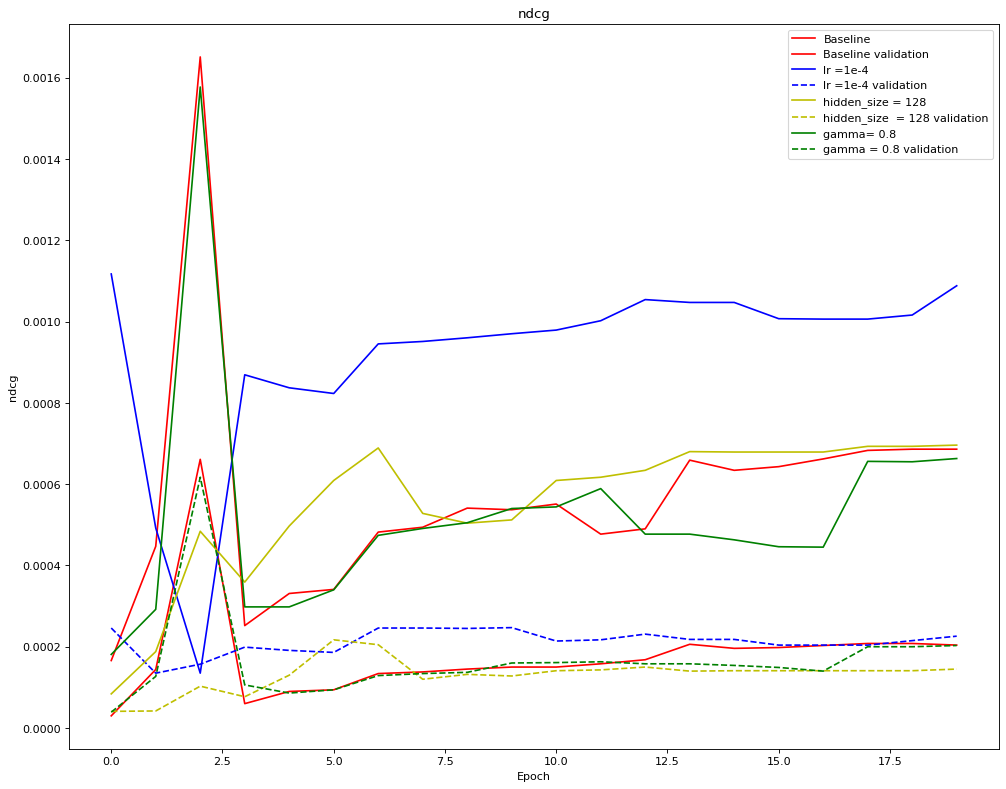

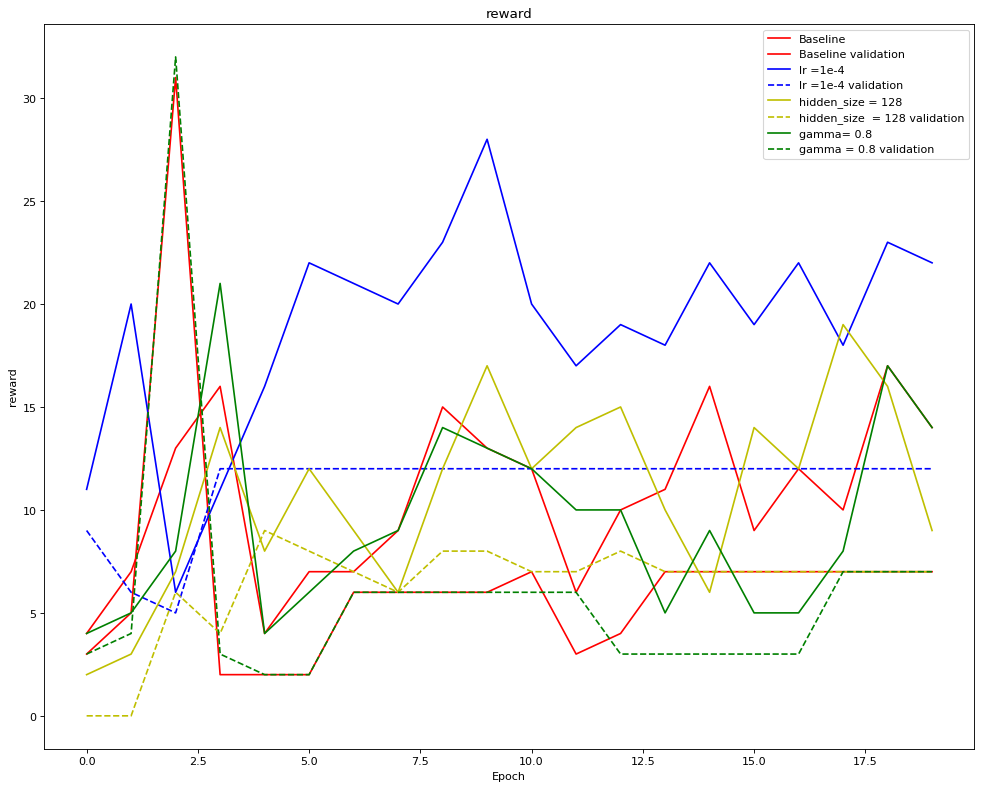

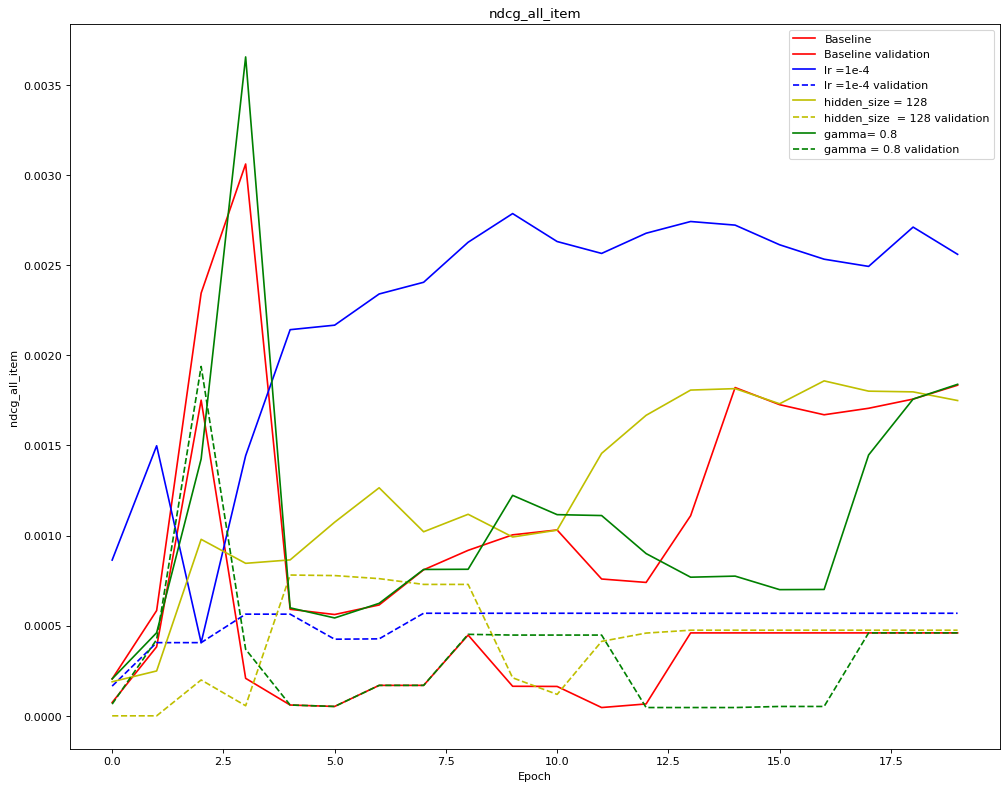

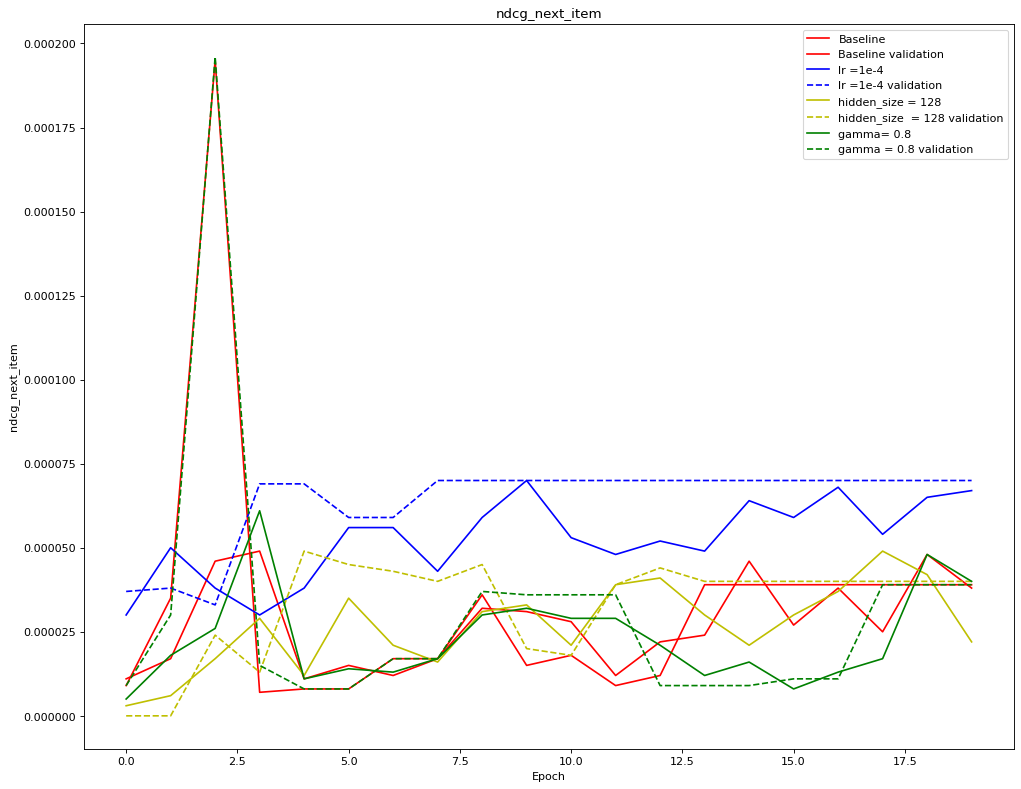

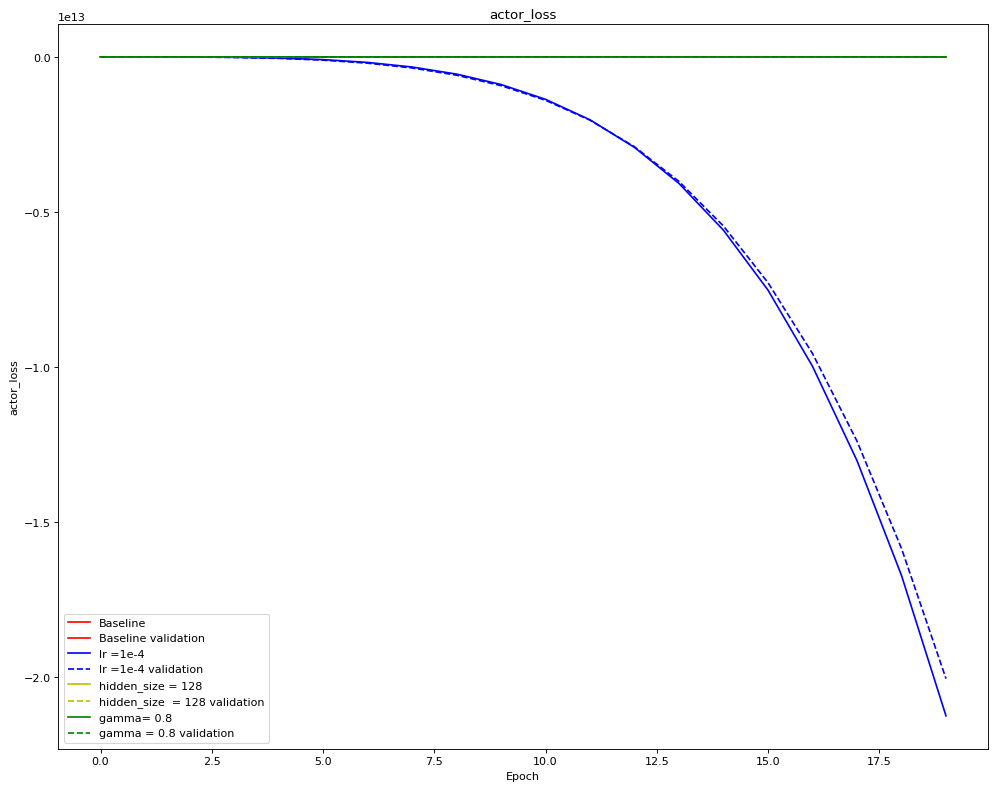

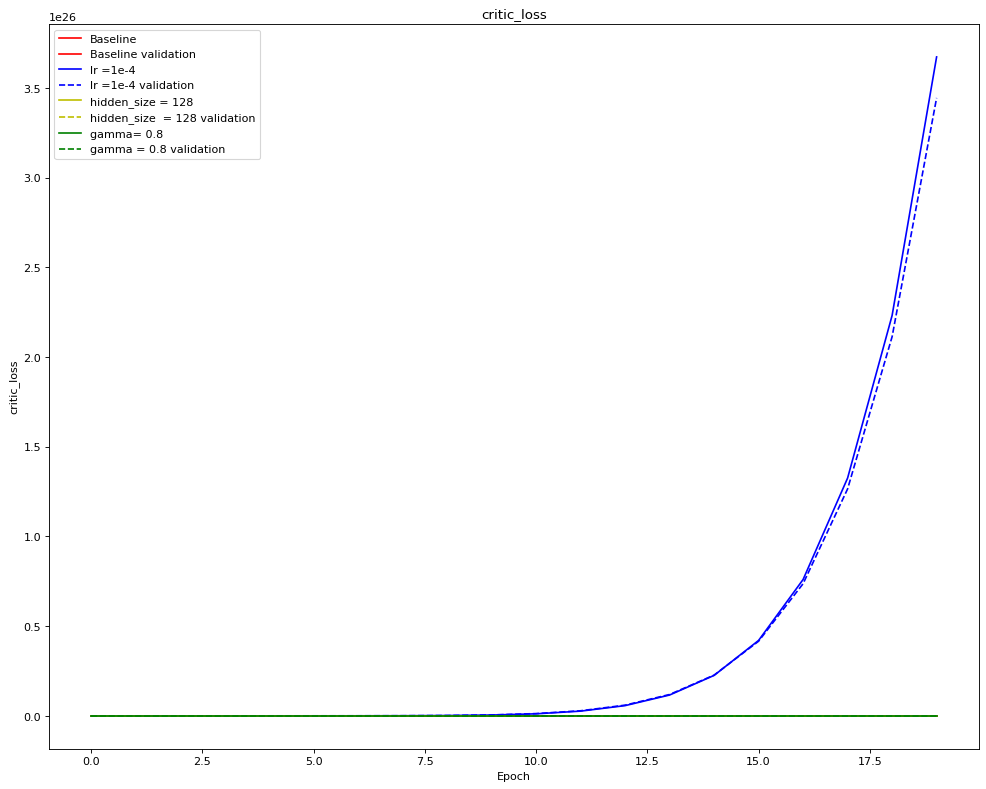

In [19]:
folder_path = "plot/ddpg"

for filee in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filee)
    Image.open(file_path).show()

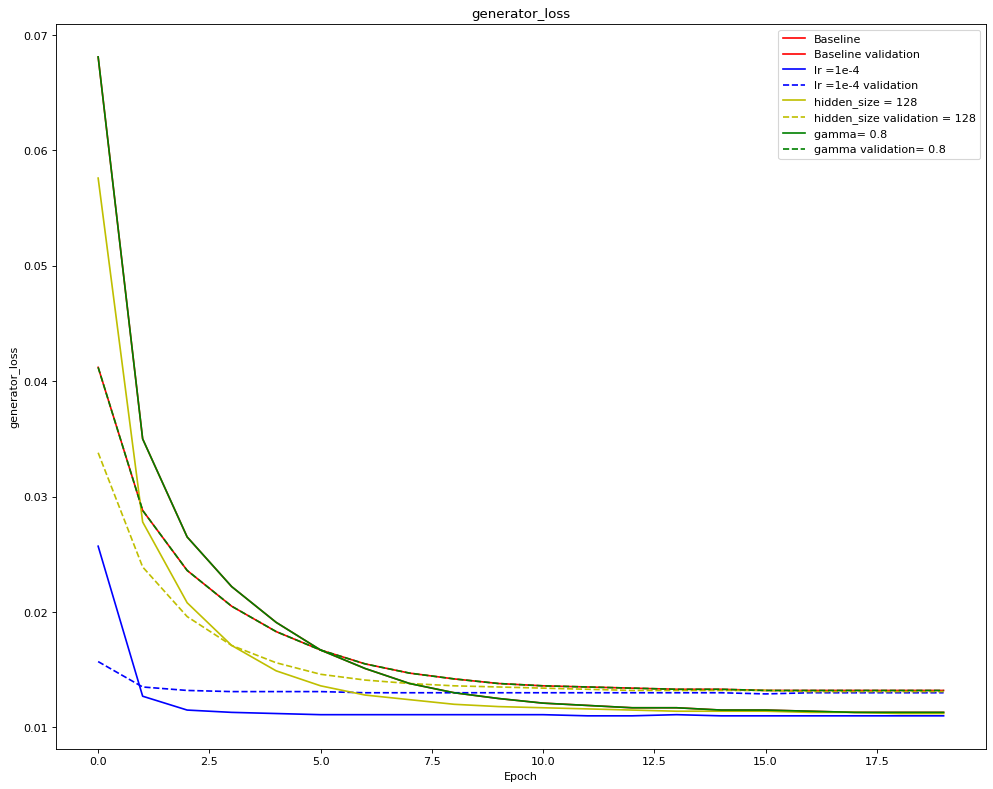

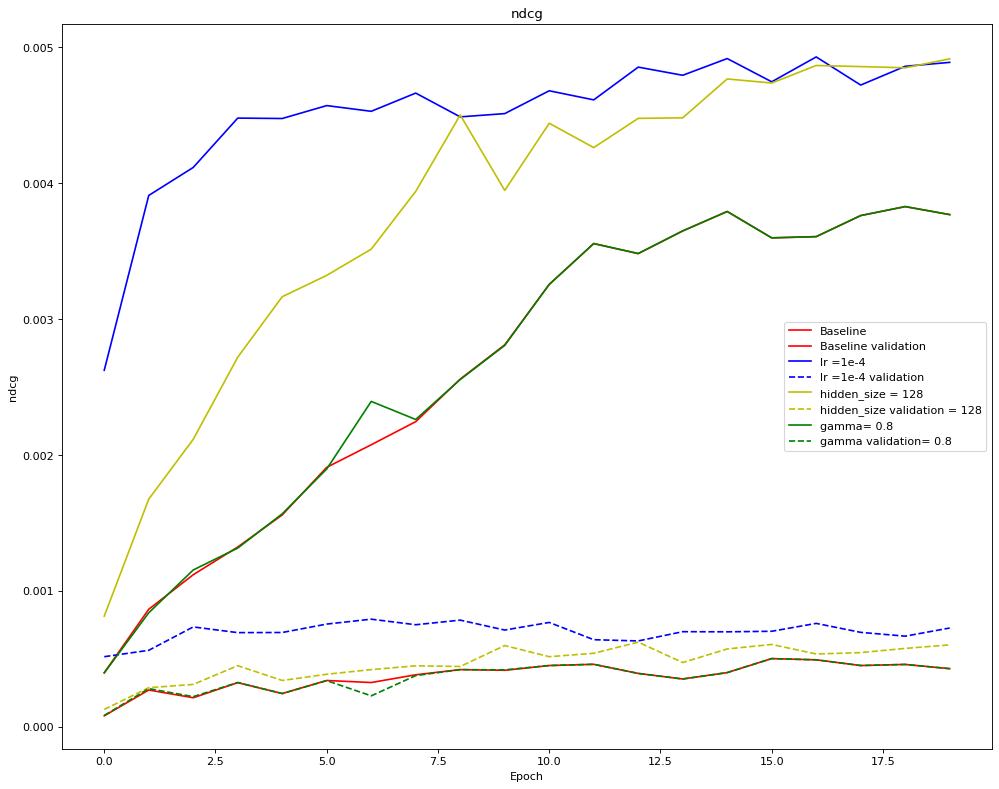

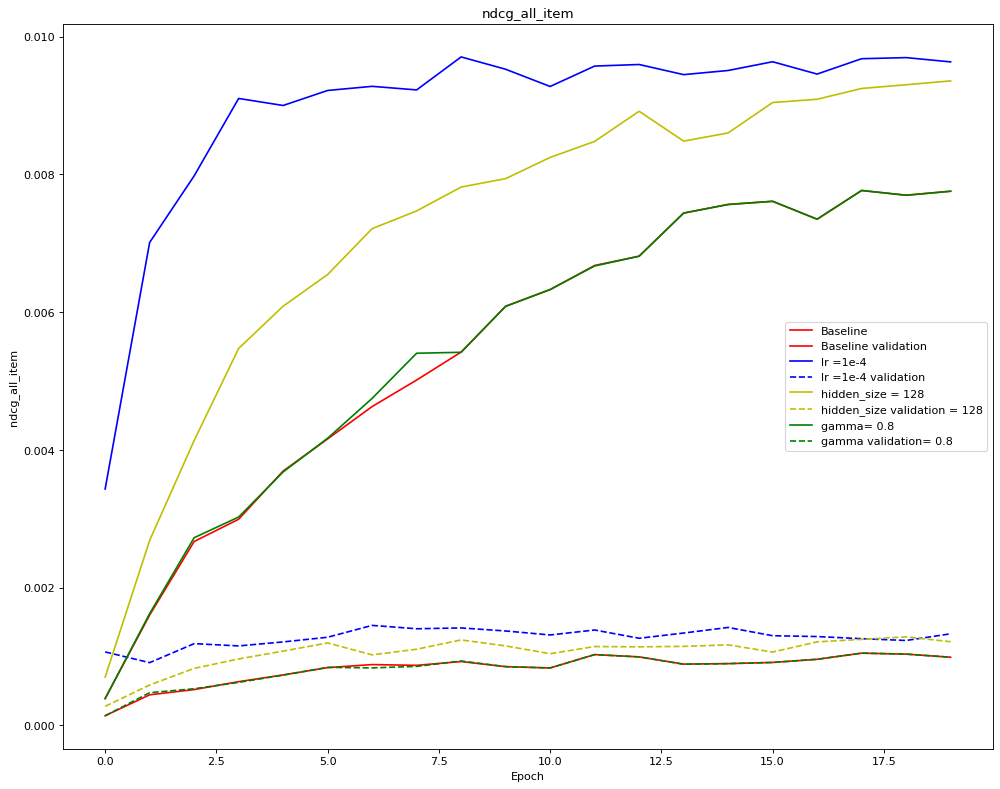

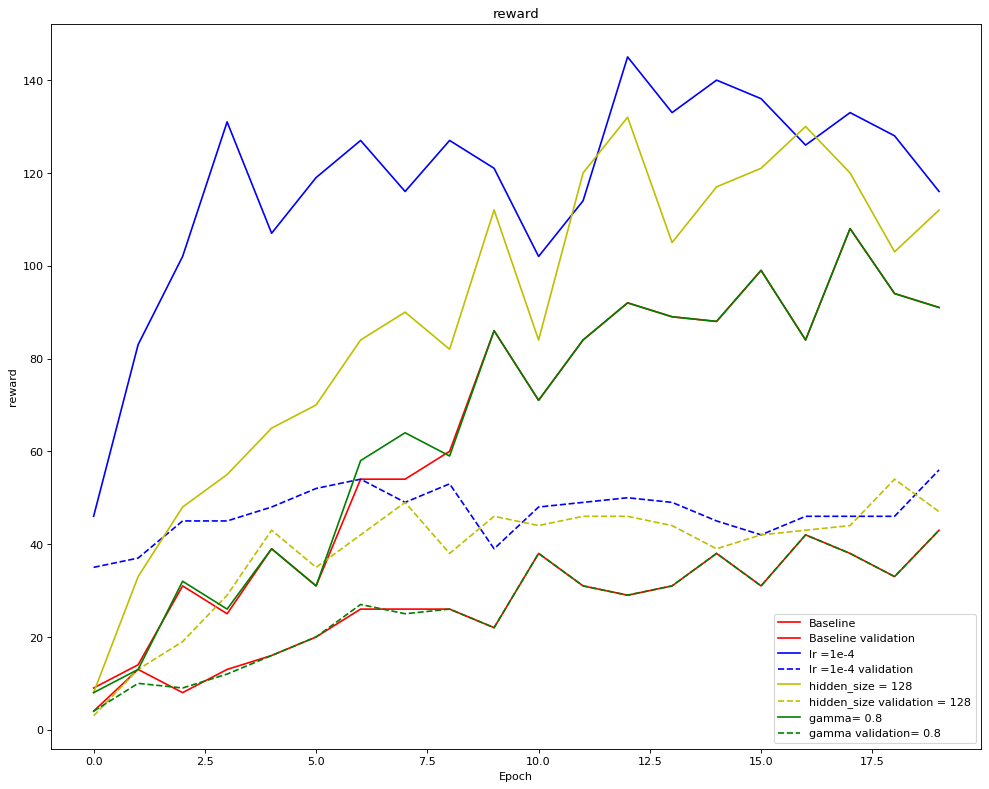

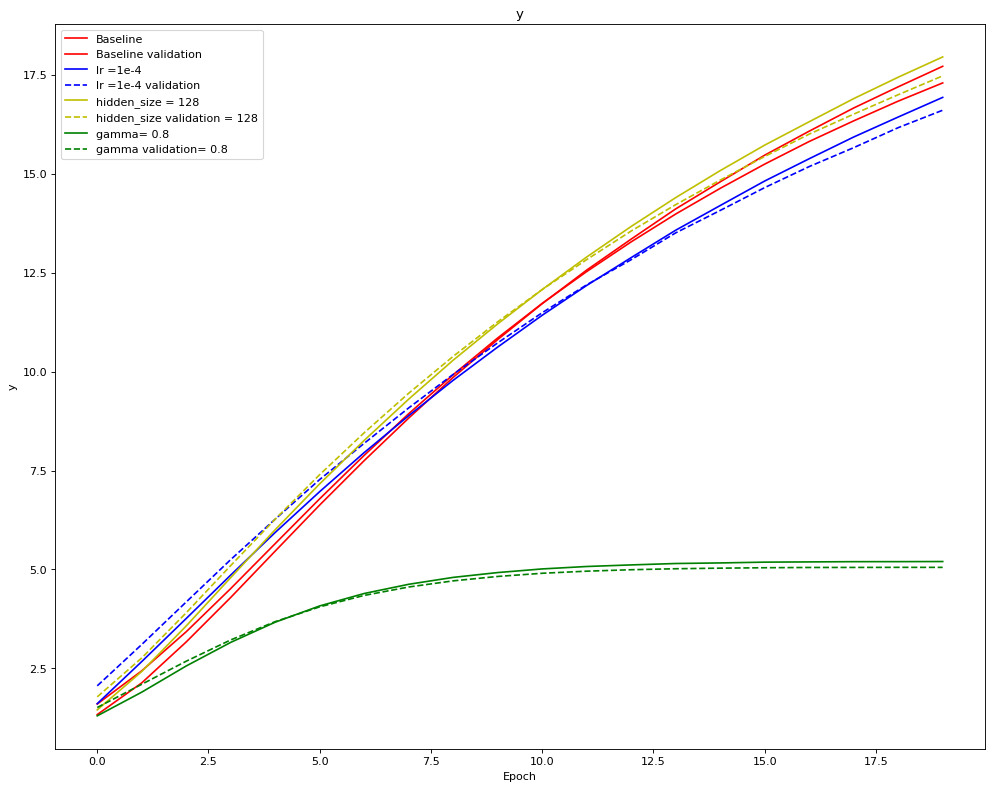

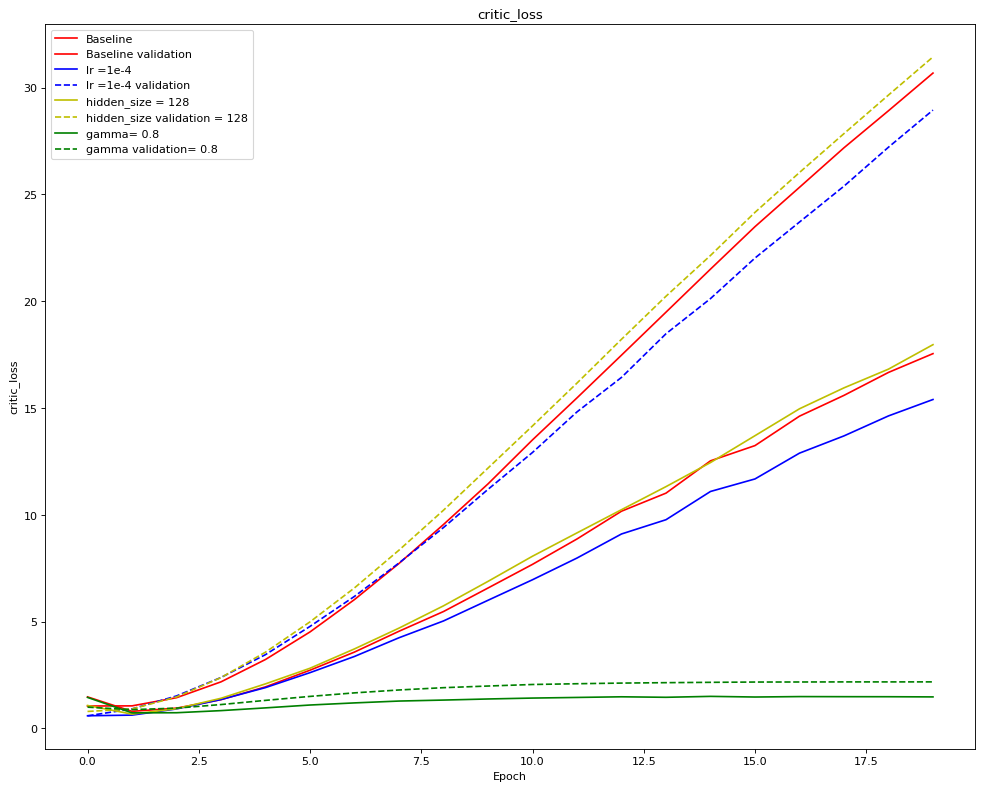

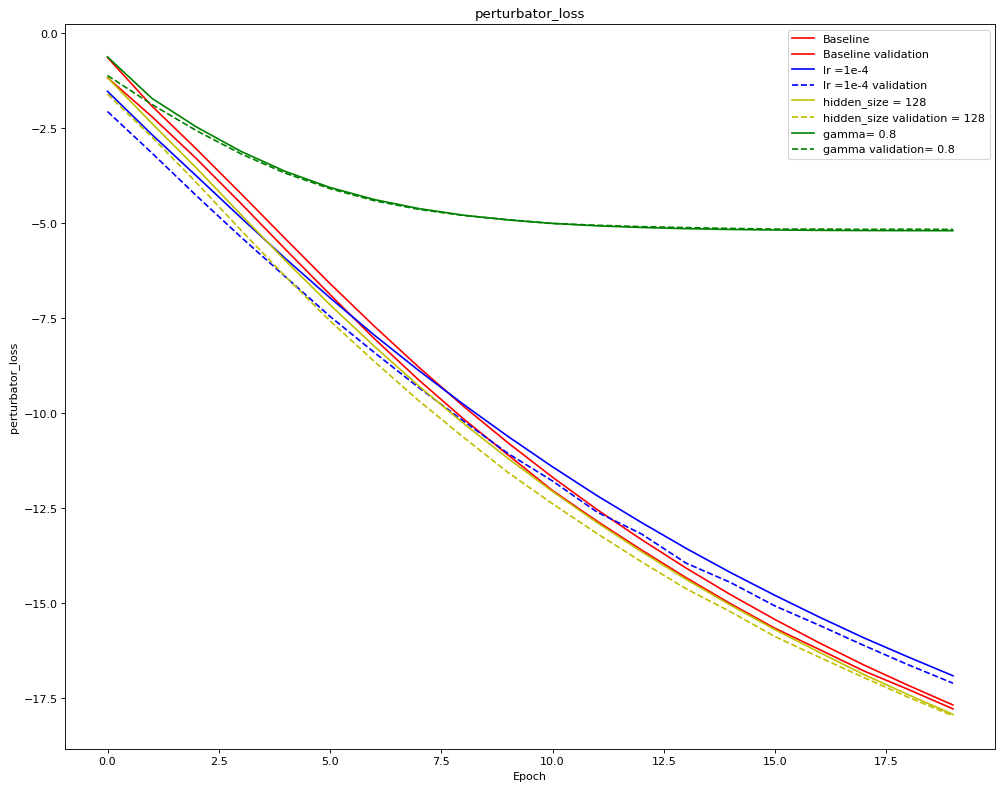

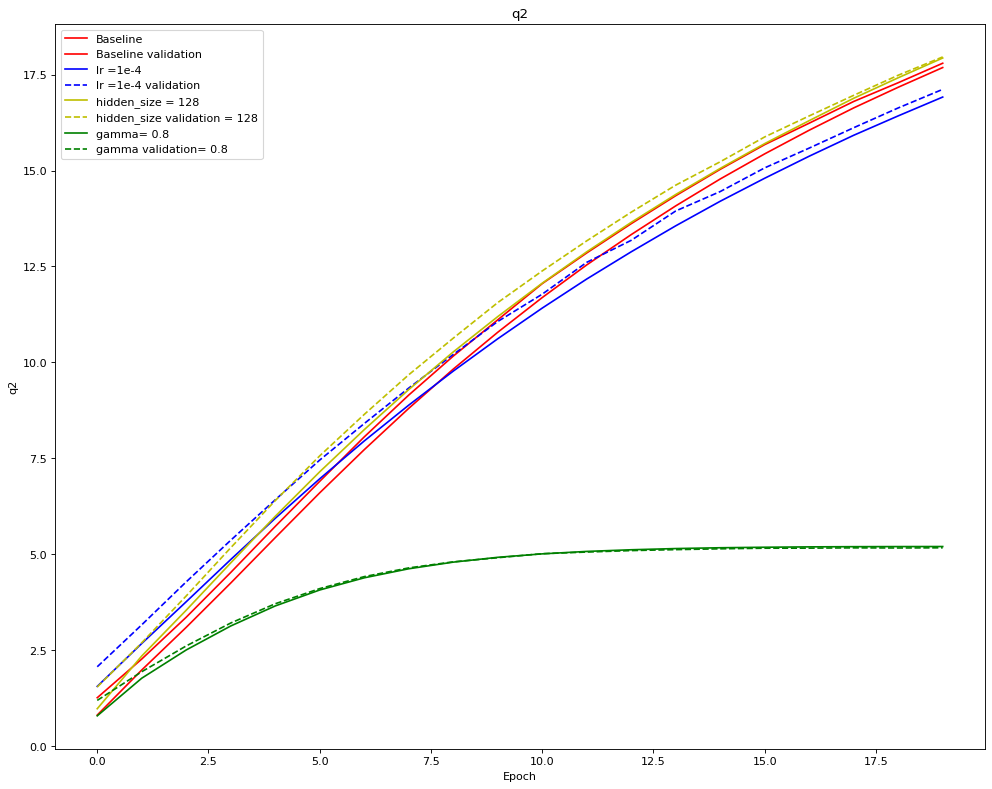

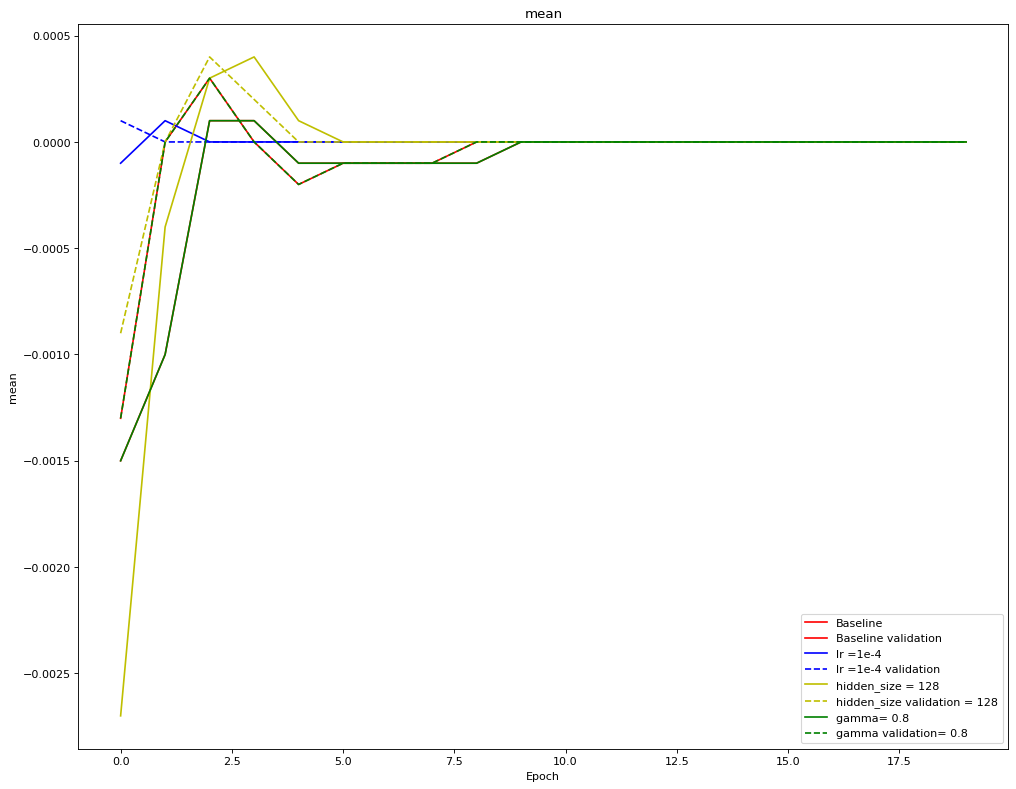

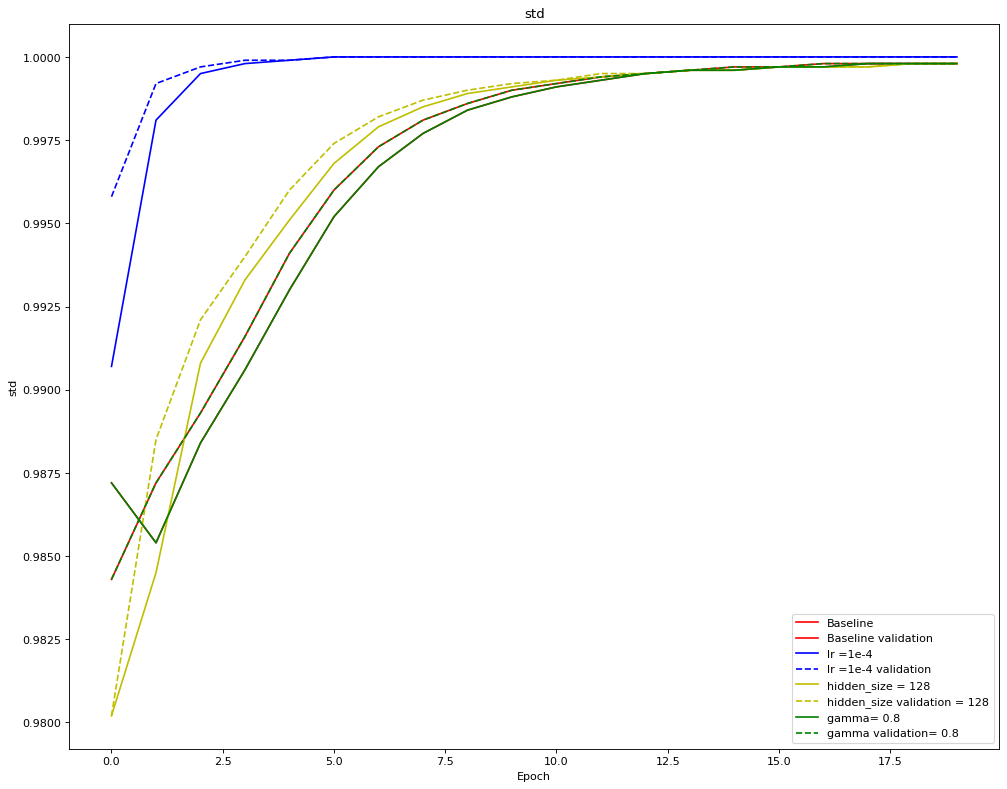

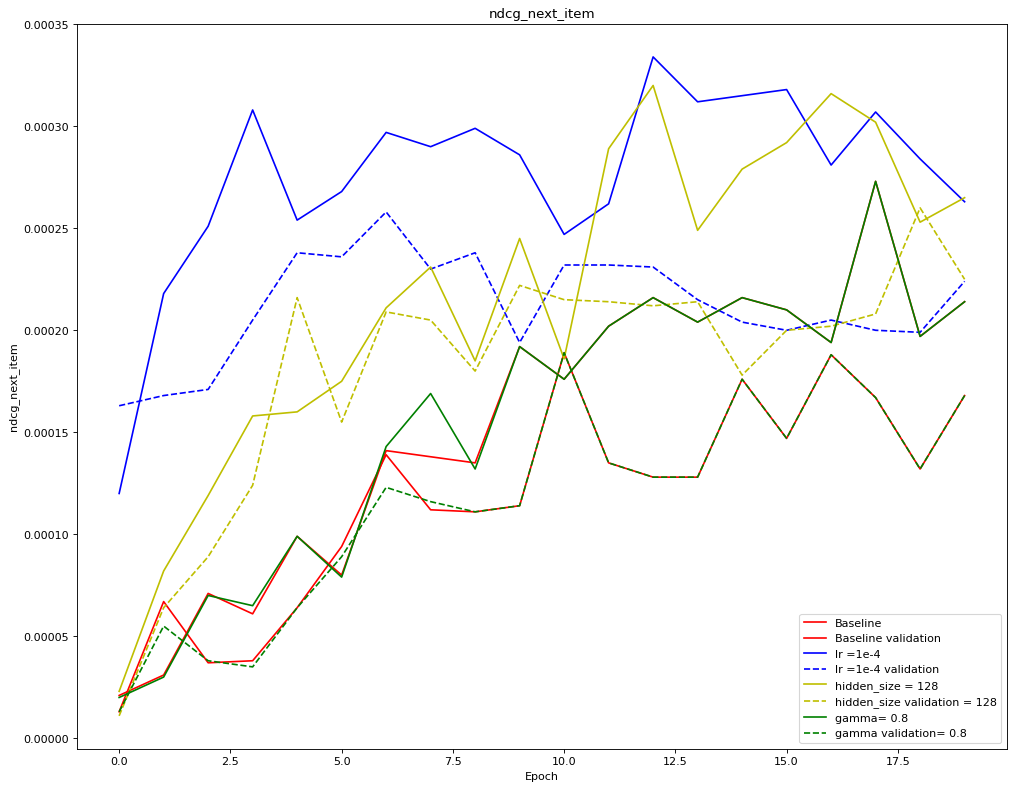

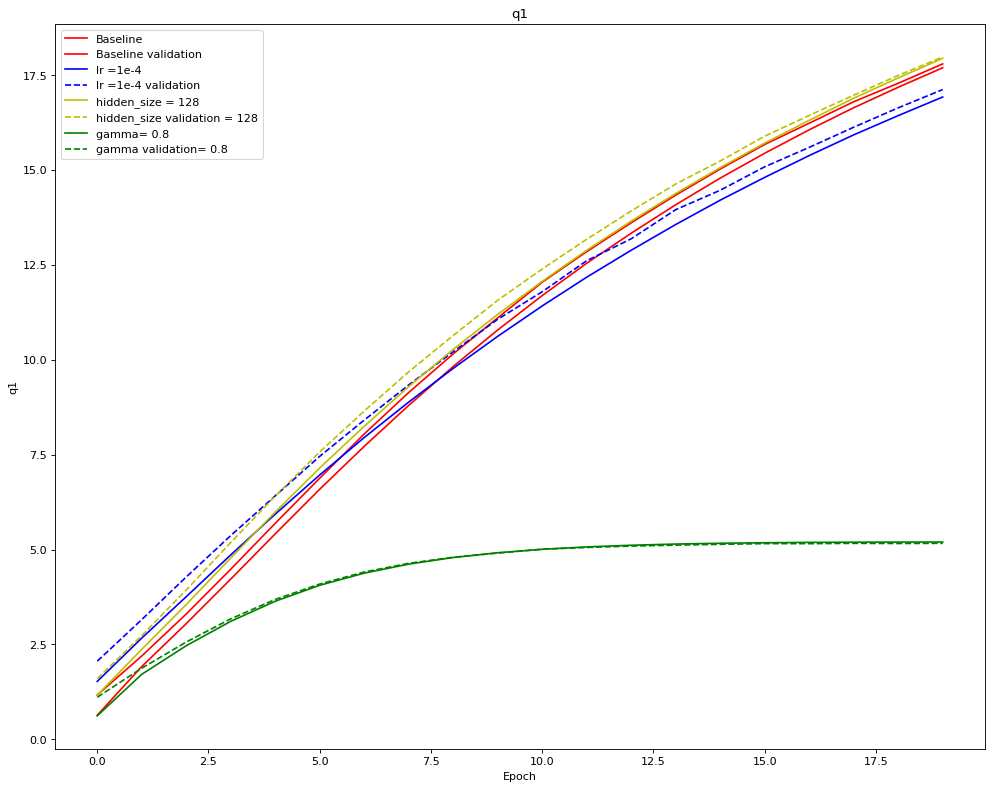

In [20]:
folder_path = "plot/bcq"

for filee in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filee)
    Image.open(file_path).show()

## Conlusion

1. Converging
2. ddpg trains faster
3. Dispite the spike in the begining, the ndcg matric is increasing.
4. Need more epochs.